In [1]:
#Decision Tree
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dilki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Predefined list of network-specific stopwords
network_stopwords = set([
    'seq', 'win', 'len', 'ack', 'udp', 'tcp', 'flags', 'ttl', 'id', 'offset', 'tos', 'length', 
    'info', 'dst', 'src', 'protocol', 'version', 'ihl', 'checksum', 'options', 'urg', 'psh', 'rst', 
    'syn', 'fin', 'payload', 'data', 'options', 'mac', 'ethernet', 'frame', 'srcport', 'dstport', 
    'tcpflags', 'ttl', 'id', 'offset', 'tos', 'flags', 'time', 'sport', 'dport'
])

In [3]:
# Including standard stopwords as well
stopwords = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 
    'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 
    'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 
    'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 
    'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
    'should', 'now'
]).union(network_stopwords)

In [4]:
# Including standard stopwords as well
all_stopwords = set(nltk_stopwords.words('english')).union(network_stopwords) 

In [5]:
# Importing the dataset
dataset = pd.read_csv('dataset - Copy (2).tsv', delimiter='\t', quoting=3)

In [6]:
# Initialize an empty list to store the logs
corpus = []
ps = PorterStemmer()

# Loop through each row in the dataset
for i in range(len(dataset)):
    info = dataset['Info'][i]
    
    # Convert non-string values to strings and handle NaNs
    if pd.isnull(info):
        info = ''
    else:
        info = str(info)
    
    # Clean the log
    log = re.sub('[^a-zA-Z0-9]', ' ', info)
    log = log.lower()
    log = log.split()
    
    # Remove stopwords and apply stemming
    log = [ps.stem(word) for word in log if not word in stopwords]
    
    # Join the words back into a single string
    log = ' '.join(log)
    
    # Append the cleaned log to the corpus
    corpus.append(log)


In [7]:
# Creating the Bag of Words model
cv = CountVectorizer(max_features=1000)
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:, 1].values

In [8]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [9]:
# Training the original Decision Tree model with default parameters
dt_classifier_original = DecisionTreeClassifier(random_state=0, max_depth=2)  # Limiting depth to prevent overfitting
dt_classifier_original.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [10]:
# Predicting the Test set results with the original Decision Tree model
dt_y_pred_original = dt_classifier_original.predict(X_test)

In [11]:
# Evaluating the original Decision Tree model
dt_accuracy_original = accuracy_score(y_test, dt_y_pred_original)
dt_precision_original = precision_score(y_test, dt_y_pred_original, average='binary')
dt_recall_original = recall_score(y_test, dt_y_pred_original)
dt_f1_original = f1_score(y_test, dt_y_pred_original, average='binary')

# Displaying the results for the original Decision Tree model
print("Original Decision Tree Model")
print(f"Accuracy: {dt_accuracy_original:.4f}")
print(f"Precision: {dt_precision_original:.4f}")
print(f"Recall: {dt_recall_original:.4f}")
print(f"F1 Score: {dt_f1_original:.4f}")

Original Decision Tree Model
Accuracy: 0.9708
Precision: 0.9602
Recall: 1.0000
F1 Score: 0.9797


In [12]:
# Defining the parameter grid for hyperparameter tuning
param_dist = {
    'criterion': ['gini'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [5, 10],
}

In [13]:
# Performing RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=0), param_distributions=param_dist, n_iter=5, cv=3, scoring='accuracy', n_jobs=-1, random_state=0)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [2, 3, 4],
                                        'min_samples_leaf': [5, 10],
                                        'min_samples_split': [5, 10]},
                   random_state=0, scoring='accuracy')

In [14]:
# Extracting the best parameters
best_params = random_search.best_params_

In [15]:
# Training the optimized Decision Tree model with the best hyperparameters on the full training set
dt_classifier_optimized = DecisionTreeClassifier(**best_params, random_state=0)
dt_classifier_optimized.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=10,
                       random_state=0)

In [16]:
# Predicting the Test set results with the optimized model
dt_y_pred_optimized = dt_classifier_optimized.predict(X_test)

In [17]:
# Evaluating the optimized Decision Tree model
dt_accuracy_optimized = accuracy_score(y_test, dt_y_pred_optimized)
dt_precision_optimized = precision_score(y_test, dt_y_pred_optimized, average='binary')
dt_recall_optimized = recall_score(y_test, dt_y_pred_optimized)
dt_f1_optimized = f1_score(y_test, dt_y_pred_optimized, average='binary')
dt_cm_optimized = confusion_matrix(y_test, dt_y_pred_optimized)

# Displaying the results for the optimized Decision Tree model
print("\nOptimized Decision Tree Model")
print(f"Best Parameters: {best_params}")
print(f"Accuracy: {dt_accuracy_optimized:.4f}")
print(f"Precision: {dt_precision_optimized:.4f}")
print(f"Recall: {dt_recall_optimized:.4f}")
print(f"F1 Score: {dt_f1_optimized:.4f}")


Optimized Decision Tree Model
Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 4, 'criterion': 'gini'}
Accuracy: 0.9867
Precision: 0.9815
Recall: 1.0000
F1 Score: 0.9906


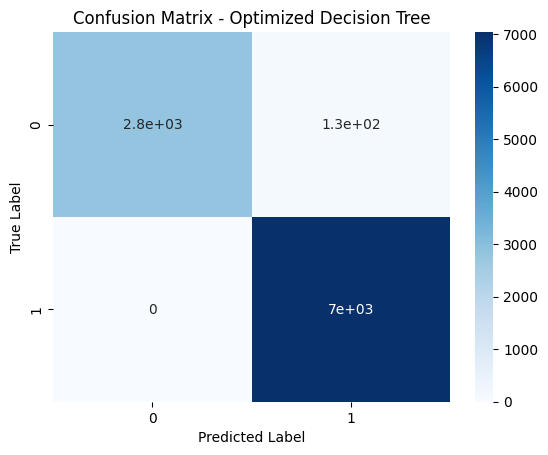

In [18]:
# Visualizing the confusion matrix of the optimized model as a heatmap
sns.heatmap(dt_cm_optimized, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Optimized Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [19]:
# Dumping the trained optimized model to a file
joblib.dump(dt_classifier_optimized, 'decision_tree_model_optimized.joblib')

['decision_tree_model_optimized.joblib']

In [20]:
# Dumping the CountVectorizer
joblib.dump(cv, 'count_vectorizer.joblib')

['count_vectorizer.joblib']

Data Visualization

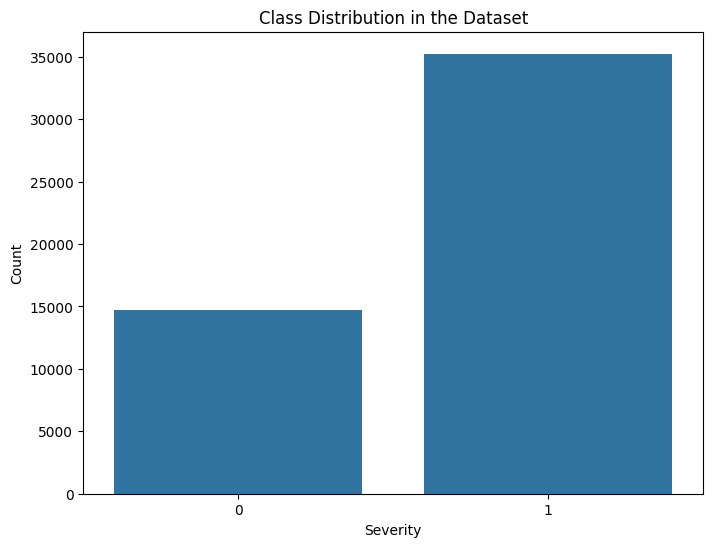

In [21]:
#Class Distribution: Visualize the distribution of classes in the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Class distribution visualization
plt.figure(figsize=(8, 6))
sns.countplot(x=dataset.iloc[:, 1])
plt.title('Class Distribution in the Dataset')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()


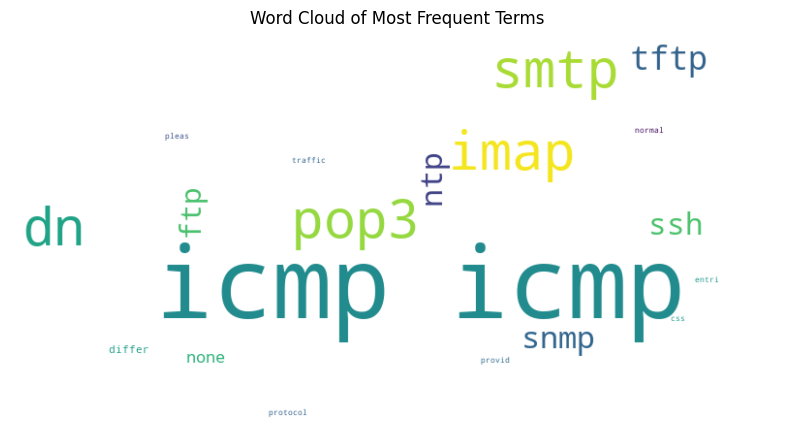

In [22]:
#Word Cloud: Generate a word cloud to visualize the most frequent terms in the corpus
from wordcloud import WordCloud

# Join all corpus texts
all_words = ' '.join(corpus)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Terms')
plt.show()


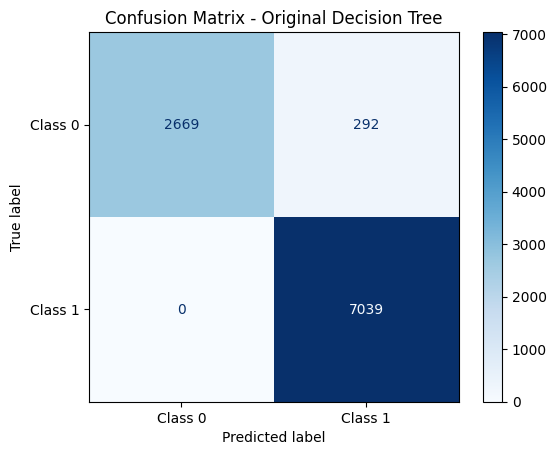

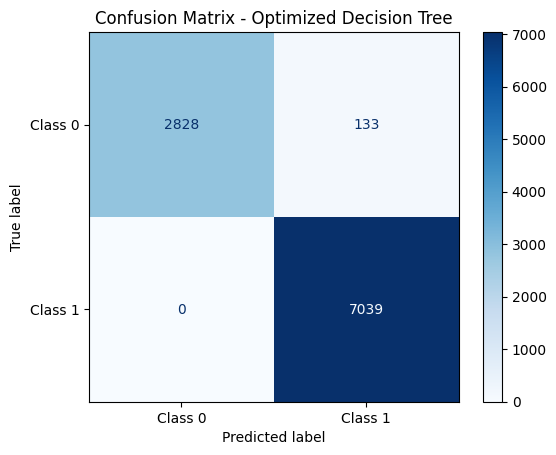

In [23]:
#Confusion Matrix: Visualize the confusion matrix for both the original and optimized Decision Tree models
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming y_test and dt_y_pred_original, dt_y_pred_optimized are already defined
# Calculate confusion matrices
cm_original = confusion_matrix(y_test, dt_y_pred_original)
cm_optimized = confusion_matrix(y_test, dt_y_pred_optimized)

# Display confusion matrix for the original Decision Tree model
disp_original = ConfusionMatrixDisplay(confusion_matrix=cm_original, display_labels=['Class 0', 'Class 1'])
disp_original.plot(cmap='Blues')
plt.title('Confusion Matrix - Original Decision Tree')
plt.show()

# Display confusion matrix for the optimized Decision Tree model
disp_optimized = ConfusionMatrixDisplay(confusion_matrix=cm_optimized, display_labels=['Class 0', 'Class 1'])
disp_optimized.plot(cmap='Blues')
plt.title('Confusion Matrix - Optimized Decision Tree')
plt.show()


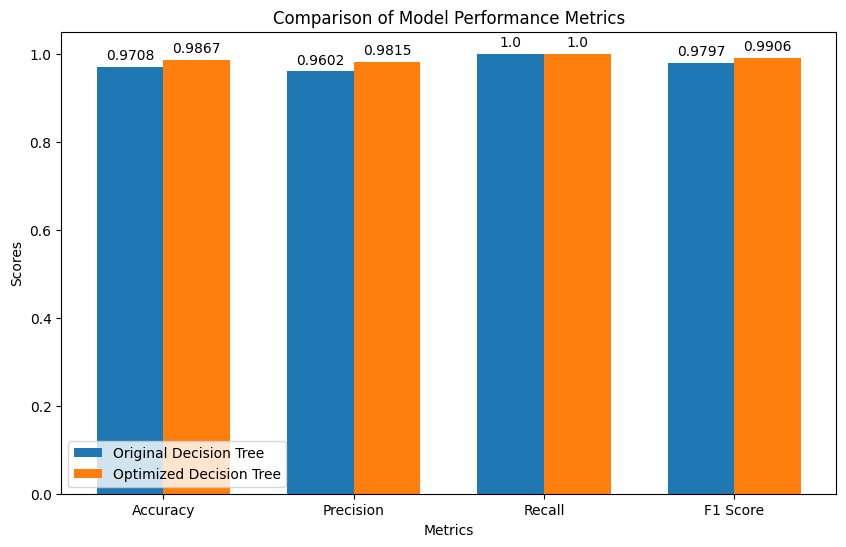

In [24]:
#Model Performance: Visualize the performance metrics of both models
import numpy as np
import matplotlib.pyplot as plt

# Assuming the performance metrics for the original and optimized models are already defined
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
original_scores = [dt_accuracy_original, dt_precision_original, dt_recall_original, dt_f1_original]
optimized_scores = [dt_accuracy_optimized, dt_precision_optimized, dt_recall_optimized, dt_f1_optimized]

# Bar plot for model performance comparison
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, original_scores, width, label='Original Decision Tree')
bars2 = ax.bar(x + width/2, optimized_scores, width, label='Optimized Decision Tree')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar displaying its height
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate('{}'.format(round(height, 4)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


                                            Info  Severity
0  5759 > 25565 [SYN] Seq=1348861952 Win=0 Len=0         1
1   14439 > 80 [ACK] Seq=458044343 Win=512 Len=0         1
2             53 > 57488 [UDP] Seq=0 Win=0 Len=0         0
3     3676 > 80 [ACK] Seq=83703914 Win=512 Len=0         1
4   7086 > 80 [ACK] Seq=1880955973 Win=512 Len=0         1
Index(['Info', 'Severity'], dtype='object')


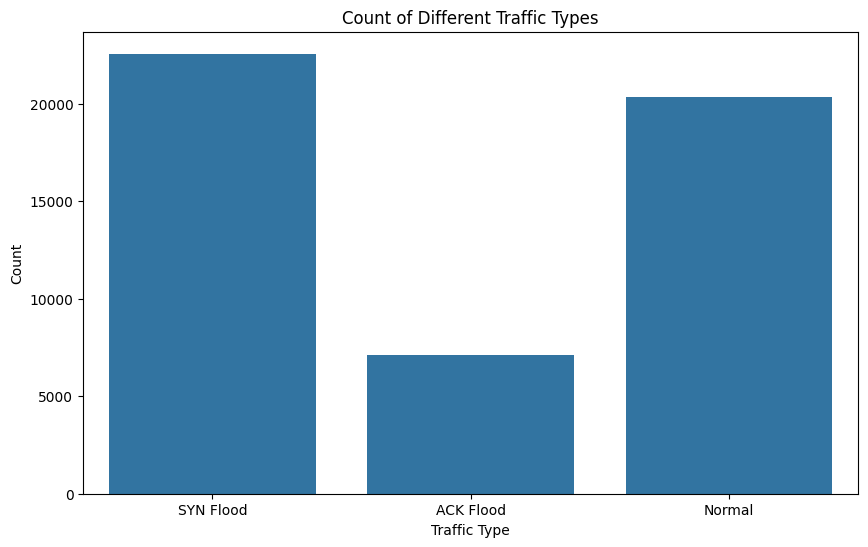

,Traffic Type,Count
0,SYN Flood,22558
1,ACK Flood,7124
2,Normal,20318


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'dataset - Copy (2).tsv'
dataset = pd.read_csv(file_path, sep='\t')

# Inspect the dataset
print(dataset.head())
print(dataset.columns)

# Assuming the column to check is named 'Info', adjust if necessary
# Fill NaN values with an empty string to avoid errors
dataset['Info'] = dataset['Info'].fillna('')

# Identify the entries for SYN flood, ACK flood, and normal traffic
syn_flood_entries = dataset[dataset['Info'].str.contains('SYN', case=False)]
ack_flood_entries = dataset[dataset['Info'].str.contains('ACK', case=False)]
normal_entries = dataset[~dataset['Info'].str.contains('SYN|ACK', case=False)]

# Count the number of entries for each type
syn_flood_count = len(syn_flood_entries)
ack_flood_count = len(ack_flood_entries)
normal_count = len(normal_entries)

# Create a DataFrame for the counts
counts_df = pd.DataFrame({
    'Traffic Type': ['SYN Flood', 'ACK Flood', 'Normal'],
    'Count': [syn_flood_count, ack_flood_count, normal_count]
})

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(x='Traffic Type', y='Count', data=counts_df)
plt.title('Count of Different Traffic Types')
plt.xlabel('Traffic Type')
plt.ylabel('Count')
plt.show()

# Display the counts
counts_df
